# Chapter 5

## Set Up

### Packages

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [3]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## 5.1 Spurious association

In [5]:
# load waffle data
waffle = load_data(WAFFLE_DIVORCE_FILE, delimiter=";")

# standardise variables
waffle_normaliser = StandardScaler()
waffle[["divorce", "marriage", "age"]] = waffle_normaliser.fit_transform(
    waffle[["Divorce", "Marriage", "MedianAgeMarriage"]]
)

First build a model for marriage rate based on age

In [6]:
n_draw = 100

with pm.Model() as m5_1:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_age = pm.Normal("beta_age", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # data
    age = pm.MutableData("age", waffle.age, dims="state")

    # linear model
    mu = pm.Deterministic("mu", alpha + beta_age * age, dims="state")

    # likelihood
    divorce = pm.Normal(
        "divorce", mu=mu, sigma=sigma, observed=waffle.divorce, dims="state"
    )

    # sample prior
    trace_5_1 = pm.sample_prior_predictive(samples=n_draw, random_seed=RANDOM_SEED)

Sampling: [alpha, beta_age, divorce, sigma]


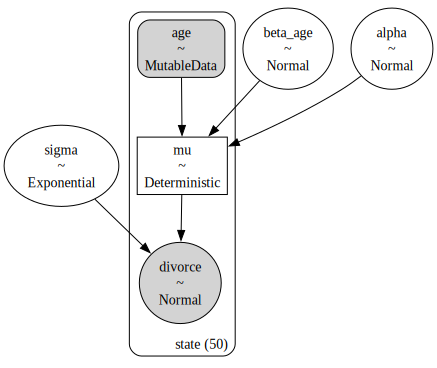

In [7]:
m5_1.to_graphviz()

Now we plot some plausible regression lines

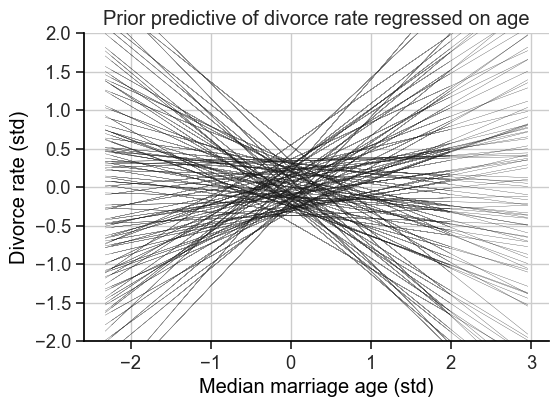

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

for draw in range(n_draw):
    ax.plot(
        trace_5_1.constant_data.age,
        trace_5_1.prior.mu.sel(chain=0, draw=draw),
        color="k",
        lw=0.2,
        alpha=0.5,
    )

ax.set(
    ylim=[-2, 2],
    xlabel="Median marriage age (std)",
    ylabel="Divorce rate (std)",
    title="Prior predictive of divorce rate regressed on age",
);

Now hit the sample button

In [9]:
with m5_1:
    trace_5_1 = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [10]:
az.summary(
    trace_5_1,
    var_names=["alpha", "beta", "sigma"],
    filter_vars="regex",
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,-0.00,0.10,-0.15,0.16
beta_age,-0.57,0.11,-0.76,-0.40
sigma,0.83,0.09,0.69,0.96


Also want to plot against the actual data.

In [11]:
def plot_posterior_compatibility_interval(trace, predictor, ax=None):
    # get the posterior data
    mu_hdi = az.hdi(trace.posterior.mu, hdi_prob=0.89)
    mu_plot_data = pd.DataFrame(
        {
            predictor: trace.constant_data[predictor],
            "mean": trace.posterior.mu.mean(dim=["chain", "draw"]),
            "hdi_lower": mu_hdi.mu.sel(hdi="lower"),
            "hdi_higher": mu_hdi.mu.sel(hdi="higher"),
        }
    ).sort_values(predictor)

    # plot
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 5))

    # plot true data
    sns.scatterplot(
        x=trace.constant_data[predictor], y=trace.observed_data.divorce, ax=ax
    )

    # plot the mean at each weight
    ax.plot(mu_plot_data[predictor], mu_plot_data["mean"], color="k")

    ax.fill_between(
        mu_plot_data[predictor],
        mu_plot_data["hdi_lower"],
        mu_plot_data["hdi_higher"],
        color="k",
        alpha=0.3,
    )

    ax.set(
        xlabel=predictor,
        ylabel="Divorce rate (std)",
        title="Posterior compatibility interval",
    )

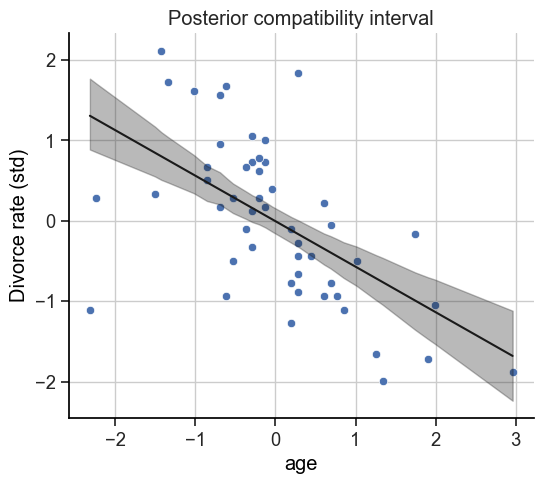

In [12]:
plot_posterior_compatibility_interval(trace_5_1, "age");

We build a similar model 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_marriage, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


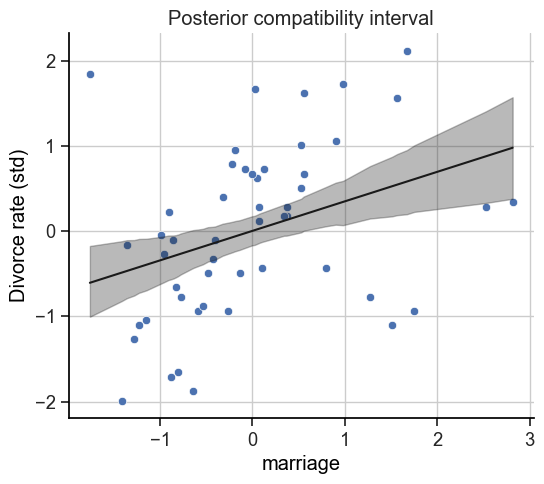

In [13]:
with pm.Model() as m5_2:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_marriage = pm.Normal("beta_marriage", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # data
    marriage = pm.MutableData("marriage", waffle.marriage, dims="state")

    # linear model
    mu = pm.Deterministic("mu", alpha + beta_marriage * marriage, dims="state")

    # likelihood
    divorce = pm.Normal(
        "divorce", mu=mu, sigma=sigma, observed=waffle.divorce, dims="state"
    )

    # sample
    trace_5_2 = pm.sample(draws=1000, random_seed=RANDOM_SEED)

plot_posterior_compatibility_interval(trace_5_2, "marriage");

### 5.1.4 Approximating the posterior

Now we create a multiple regression model

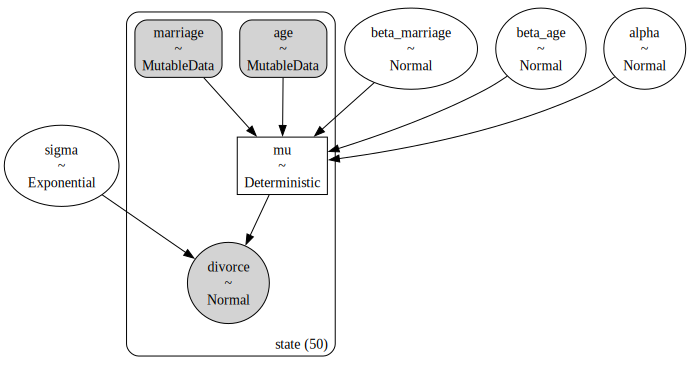

In [14]:
with pm.Model() as m5_3:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_age = pm.Normal("beta_age", mu=0, sigma=0.5)
    beta_marriage = pm.Normal("beta_marriage", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # data
    age = pm.MutableData("age", waffle.age, dims="state")
    marriage = pm.MutableData("marriage", waffle.marriage, dims="state")

    # linear model
    mu = pm.Deterministic(
        "mu", alpha + beta_age * age + beta_marriage * marriage, dims="state"
    )

    # likelihood
    divorce = pm.Normal(
        "divorce", mu=mu, sigma=sigma, observed=waffle.divorce, dims="state"
    )


m5_3.to_graphviz()

Now let's sample

In [15]:
with m5_3:
    trace_5_3 = pm.sample(draws=1000)

az.summary(
    trace_5_3,
    var_names=["alpha", "beta", "sigma"],
    filter_vars="regex",
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, beta_marriage, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
alpha,-0.00,0.10,-0.16,0.16
beta_age,-0.60,0.16,-0.88,-0.38
beta_marriage,-0.06,0.15,-0.29,0.19
sigma,0.84,0.09,0.70,0.97


Plot the feature coefficients for the different models.

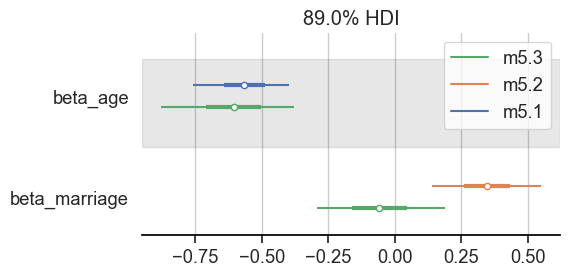

In [16]:
az.plot_forest(
    [trace_5_1, trace_5_2, trace_5_3],
    model_names=["m5.1", "m5.2", "m5.3"],
    var_names="beta",
    filter_vars="regex",
    hdi_prob=0.89,
    combined=True,
    figsize=(6, 3),
)
plt.tight_layout();

### 5.1.5 Plotting multivariate posteriors

#### 5.1.5.1 Predictor residual plots

First define a model regression marriage rate and median marriage age:

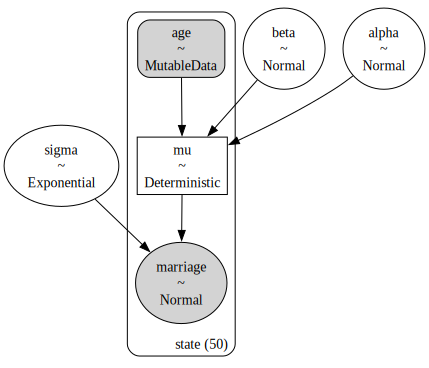

In [17]:
with pm.Model() as m5_4:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta = pm.Normal("beta", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # data
    age = pm.MutableData("age", waffle.age, dims="state")

    # linear model
    mu = pm.Deterministic("mu", alpha + beta * age, dims="state")

    # likelihood
    marriage = pm.Normal(
        "marriage", mu=mu, sigma=sigma, observed=waffle.marriage, dims="state"
    )


m5_4.to_graphviz()

Now sample and plot residuals.

In [18]:
with m5_4:
    trace_5_4 = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Get mean

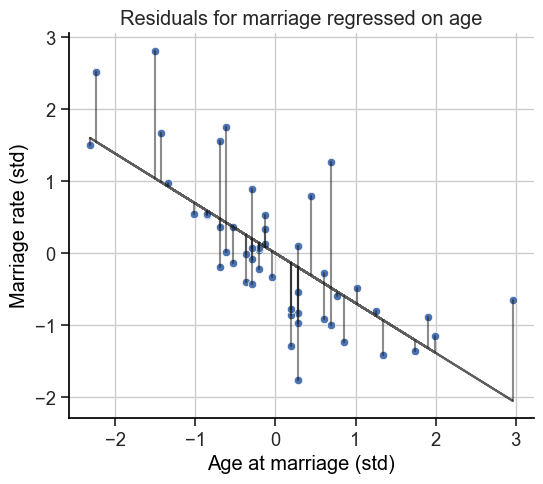

In [19]:
# plot
fig, ax = plt.subplots(figsize=(6, 5))

# plot true data
sns.scatterplot(
    x=trace_5_4.constant_data.age, y=trace_5_4.observed_data.marriage, ax=ax
)

# plot the mean at each weight
ax.plot(
    trace_5_4.constant_data.age,
    trace_5_4.posterior.mu.mean(dim=["chain", "draw"]),
    color="k",
    alpha=0.7,
)

# plot lines from mu to observed value
ax.plot(
    (trace_5_4.constant_data.age, trace_5_4.constant_data.age),
    (
        trace_5_4.posterior.mu.mean(dim=["chain", "draw"]),
        trace_5_4.observed_data.marriage,
    ),
    color="k",
    alpha=0.5,
)

ax.set(
    xlabel="Age at marriage (std)",
    ylabel="Marriage rate (std)",
    title="Residuals for marriage regressed on age",
);

Now we regress divorce rate on the residuals

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


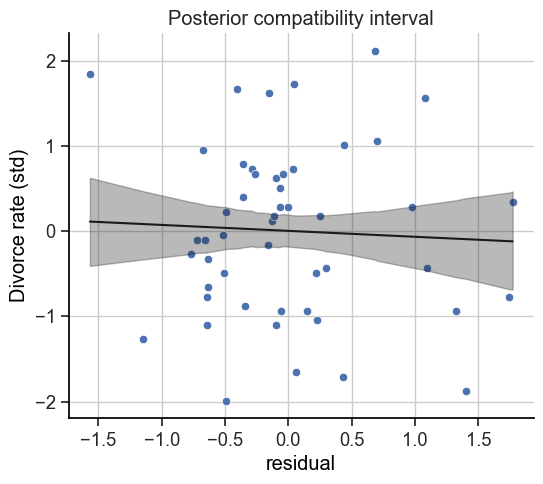

In [20]:
# get mean of mu for all data points
mu_mean = trace_5_4.posterior.mu.mean(dim=["chain", "draw"])
residuals = trace_5_4.observed_data.marriage - mu_mean

with pm.Model() as m5_4a:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta = pm.Normal("beta", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # data
    residual = pm.MutableData("residual", residuals, dims="state")

    # linear model
    mu = pm.Deterministic("mu", alpha + beta * residual, dims="state")

    # likelihood
    divorce = pm.Normal(
        "divorce", mu=mu, sigma=sigma, observed=waffle.divorce, dims="state"
    )

    # sample
    trace_5_4a = pm.sample(draws=1000, random_seed=RANDOM_SEED)

plot_posterior_compatibility_interval(trace_5_4a, "residual");

This supports the hypothesis that divorce rate is conditionally independent of marriage rate given marriage age.

#### 5.1.5.3 Counterfactual plots

We generate separate models for the influence of A and M on D and for the influence of A on M.

In [21]:
with pm.Model() as m5_3a:
    # data
    age = pm.MutableData("age", waffle.age, dims="state")

    # A -> M
    # priors
    alpha_M = pm.Normal("alpha_M", mu=0, sigma=0.2)
    beta_AM = pm.Normal("beta_AM", mu=0, sigma=0.5)
    sigma_M = pm.Exponential("sigma_M", lam=1)

    # linear model
    mu_M = pm.Deterministic("mu_M", alpha_M + beta_AM * age, dims="state")

    # likelihood
    marriage = pm.Normal(
        "marriage", mu=mu_M, sigma=sigma_M, observed=waffle.marriage, dims="state"
    )

    # A -> D <- M
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_A = pm.Normal("beta_A", mu=0, sigma=0.5)
    beta_M = pm.Normal("beta_M", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # linear model
    mu = pm.Deterministic("mu", alpha + beta_A * age + beta_M * marriage, dims="state")

    # likelihood
    divorce = pm.Normal(
        "divorce", mu=mu, sigma=sigma, observed=waffle.divorce, dims="state"
    )

    # sample
    trace_5_3a = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_M, beta_AM, sigma_M, alpha, beta_A, beta_M, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


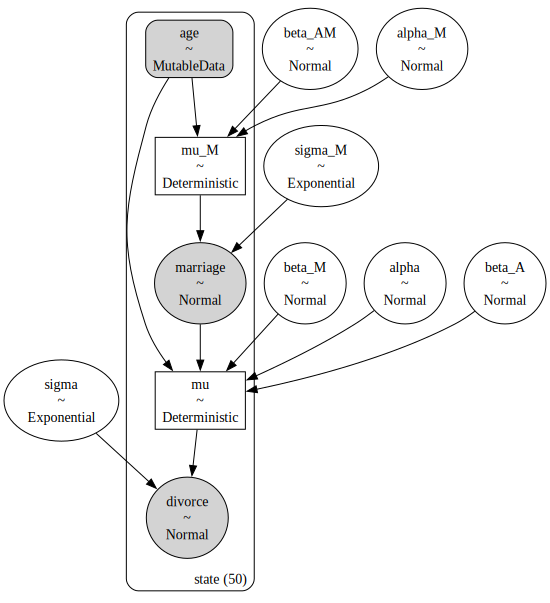

In [22]:
m5_3a.to_graphviz()

Set new age values and sample the posterior predictive.
It automatically carries the posterior predictions through `marriage`.

In [23]:
with m5_3a:
    pm.set_data({"age": np.linspace(-2, 2, 30)})
    trace_5_3a = pm.sample_posterior_predictive(
        trace_5_3a,
        var_names=["marriage", "divorce"],
        extend_inferencedata=True,
        predictions=True,
    )

Sampling: [divorce, marriage]


Plot the counterfactual posterior predictions

In [24]:
def plot_counterfactual_against_age(trace, counterfactual_var, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(5, 4))

    ax.plot(
        trace.predictions_constant_data.age,
        trace.predictions[counterfactual_var].mean(dim=["chain", "draw"]),
        color="k",
    )

    marriage_hdi = az.hdi(trace.predictions[counterfactual_var], hdi_prob=0.89)
    ax.fill_between(
        trace.predictions_constant_data.age,
        marriage_hdi[counterfactual_var].sel(hdi="lower"),
        marriage_hdi[counterfactual_var].sel(hdi="higher"),
        color="k",
        alpha=0.2,
    )

    ax.set(
        xlabel="Manipulated age",
        ylabel=f"Counterfactual {counterfactual_var}",
        title=f"Counterfactual effect age → {counterfactual_var}",
    )

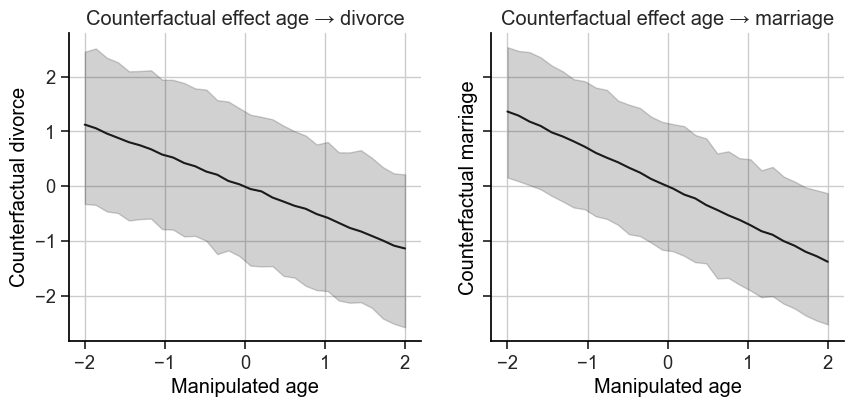

In [25]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))

plot_counterfactual_against_age(trace_5_3a, "divorce", ax=axs[0])
plot_counterfactual_against_age(trace_5_3a, "marriage", ax=axs[1])

Estimate the effect of increasing marriage age from 20 to 30 (remember that we need to standardise the data).

In [26]:
# standardise age values
ages = np.array([20, 30])
ages_ext = np.array([ages] * 3).T
ages_std = waffle_normaliser.transform(ages_ext)[:, 2]

with m5_3a:
    pm.set_data({"age": ages_std})
    trace_5_3b = pm.sample_posterior_predictive(
        trace_5_3a,
        predictions=True,
    )

# get mean for predicted values
divorce_pred_means = trace_5_3b.predictions.divorce.mean(dim=["chain", "draw"])

# transform back to un-standardised space
divorces_std = divorce_pred_means.values
divorces_std_ext = np.array([divorces_std] * 3).T
divorces = waffle_normaliser.inverse_transform(divorces_std_ext)[:, 0]

divorce_change = divorces[1] - divorces[0]
print(divorce_change)

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Sampling: [divorce, marriage]


-8.29261479770618


So an increase of 10 in the marriage age should cause a drop of 8.3% in the divorce rate.

It isn't simple to change the value of marriage in PyMC because it doesn't see it as a Mutable data.
We can get round this by essentially recreating the observed variables.

In [27]:
with m5_3a:
    age_counterfact = pm.ConstantData(
        "age_counterfact", np.zeros(30), dims="counterfact"
    )
    marriage_counterfact = pm.ConstantData(
        "marriage_counterfact", np.linspace(-2, 2, 30), dims="counterfact"
    )
    divorce_counterfact = pm.Normal(
        "divorce_counterfact",
        mu=alpha + beta_A * age_counterfact + beta_M * marriage_counterfact,
        sigma=sigma,
        dims="counterfact",
    )

    # sample
    trace_5_3a_counterfact = pm.sample_posterior_predictive(
        trace_5_3a,
        var_names=["age_counterfact", "marriage_counterfact", "divorce_counterfact"],
        predictions=True,
    )

Sampling: [divorce_counterfact]


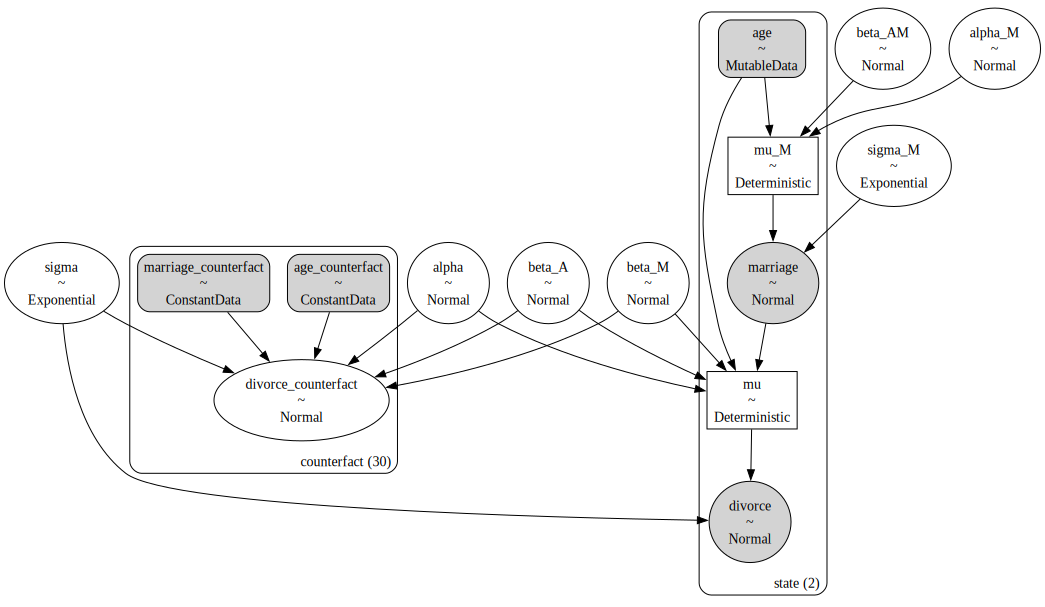

In [28]:
m5_3a.to_graphviz()

And we can plot the counterfactual effect of marriage on divorce.

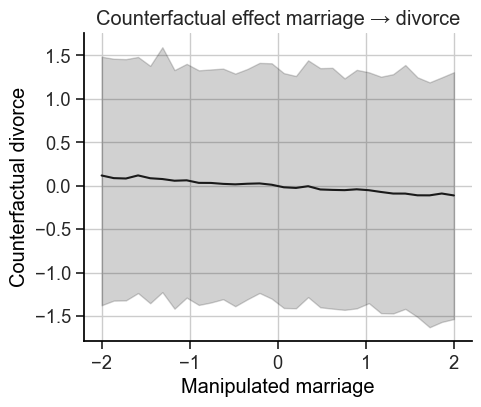

In [29]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(
    trace_5_3a_counterfact.predictions_constant_data.marriage_counterfact,
    trace_5_3a_counterfact.predictions.divorce_counterfact.mean(dim=["chain", "draw"]),
    color="k",
)

marriage_hdi = az.hdi(
    trace_5_3a_counterfact.predictions.divorce_counterfact, hdi_prob=0.89
)
ax.fill_between(
    trace_5_3a_counterfact.predictions_constant_data.marriage_counterfact,
    marriage_hdi.divorce_counterfact.sel(hdi="lower"),
    marriage_hdi.divorce_counterfact.sel(hdi="higher"),
    color="k",
    alpha=0.2,
)

ax.set(
    xlabel="Manipulated marriage",
    ylabel="Counterfactual divorce",
    title="Counterfactual effect marriage → divorce",
);

## 5.2 Masked Relationship

Load and clean the data

In [30]:
# load data
milk = load_data(MILK_FILE, delimiter=";")

# get log mass
milk["log_mass"] = np.log(milk["mass"])

# rename variables
milk = milk.rename(
    columns={
        "kcal.per.g": "kcal_per_g",
        "neocortex.perc": "neocortex_perc",
    }
)

# standardise variables
cols = ["kcal_per_g", "neocortex_perc", "log_mass"]
milk_normaliser = StandardScaler()
milk_normaliser.fit(milk[cols])

milk_norm = pd.DataFrame(
    data=milk_normaliser.transform(milk[cols]),
    columns=cols,
)

# drop missing values
milk_norm = milk_norm.dropna()

We can fit either single regression or multiple regressions.

In [31]:
def fit_linear_kcal_per_g_model(milk_norm, features):
    "Generate model with given feature set"
    coords = {"features": features}
    with pm.Model(coords=coords) as model:
        # data
        feature_data = pm.MutableData(
            "feature_data", milk_norm[features], dims=("species", "features")
        )

        # priors
        alpha = pm.Normal("alpha", mu=0, sigma=0.2)
        beta = pm.Normal("beta", mu=0, sigma=0.5, dims="features")
        sigma = pm.Exponential("sigma", lam=1)

        # mean
        mu = pm.Deterministic("mu", alpha + feature_data @ beta, dims="species")

        # likelihood
        kcal_per_g = pm.Normal(
            "kcal_per_g",
            mu=mu,
            sigma=sigma,
            observed=milk_norm.kcal_per_g,
            dims="species",
        )

        # sample
        trace = pm.sample(random_seed=RANDOM_SEED)

    return model, trace

Sample the posterior predictive while varying one feature over the natural range and keeping the other constant at zero.

In [32]:
def sample_posterior_predictive_for_varying_feature(
    model, trace, feature, n_feature_vals=30
):
    "Sample the posterior predictive with the feature varying and all others 0"
    features = model.coords["features"]
    if not feature in features:
        raise ValueError(f"{feature} not in model feature set")

    with model:
        # get original feature data
        feature_data = trace.constant_data.feature_data

        # define new data - vary one feature, keep the other at 0
        feature_data_new = pd.DataFrame(columns=features)
        feature_data_new[feature] = np.linspace(
            feature_data.sel(features=feature).min() - 0.15,
            feature_data.sel(features=feature).max() + 0.15,
            n_feature_vals,
        )
        feature_data_new = feature_data_new.fillna(0)
        pm.set_data({"feature_data": feature_data_new})

        # sample posterior predictive with new data
        pp_trace = pm.sample_posterior_predictive(
            trace,
            var_names=["mu", "kcal_per_g"],
            predictions=True,
            random_seed=RANDOM_SEED,
        )

    return pp_trace

In [33]:
def plot_posterior_predictive_for_varying_feature(
    trace, feature, observed_data=None, ax=None
):
    "Plot the posterior predictions for one varying feature. Optionally plot observed data."
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 5))

    if observed_data is not None:
        sns.scatterplot(
            x=observed_data[feature],
            y=observed_data["kcal_per_g"],
            ax=ax,
        )

    # plot mean predictions
    ax.plot(
        trace.predictions_constant_data.feature_data.sel(features=feature),
        trace.predictions.mu.mean(dim=["chain", "draw"]),
        color="k",
    )

    # plot mu HDI
    mu_hdi = az.hdi(trace.predictions.mu, hdi_prob=0.89)
    ax.fill_between(
        trace.predictions_constant_data.feature_data.sel(features=feature),
        mu_hdi.mu.sel(hdi="lower"),
        mu_hdi.mu.sel(hdi="higher"),
        color="k",
        alpha=0.3,
    )

    ax.set(
        xlabel=feature,
        ylabel="kcal_per_g",
    )

We plot all possibilities together - single regressions and multiple regressions holding one feature constant.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [kcal_per_g]


Sampling: [kcal_per_g]


Sampling: [kcal_per_g]


Sampling: [kcal_per_g]


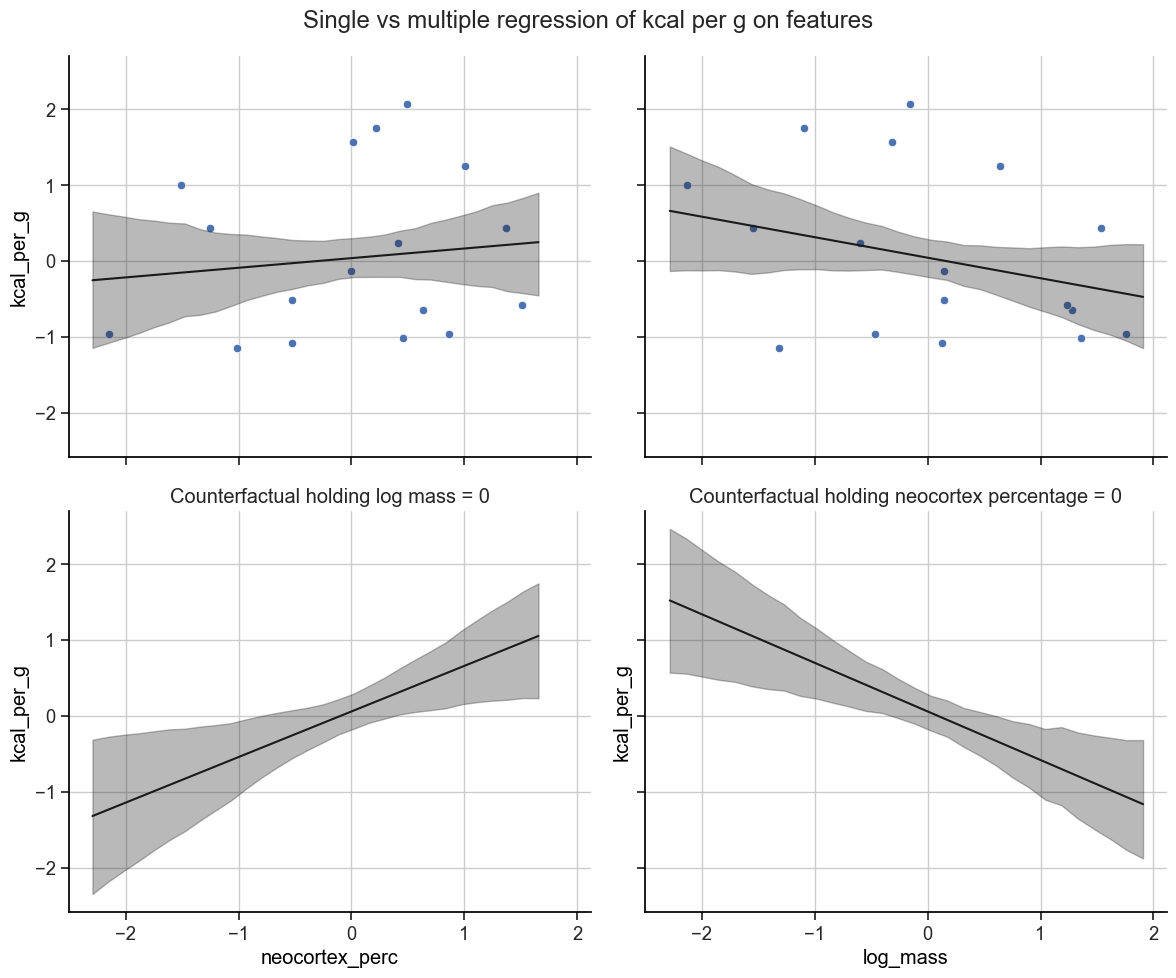

In [35]:
all_features = ["neocortex_perc", "log_mass"]
n_features = len(all_features)

ax_width = 6
fig_width = n_features * ax_width

fig, axs = plt.subplots(
    nrows=2, ncols=n_features, sharex=True, sharey=True, figsize=(fig_width, 10)
)

# fit all different models
m5_5, trace_5_5 = fit_linear_kcal_per_g_model(milk_norm, features=["neocortex_perc"])
m5_6, trace_5_6 = fit_linear_kcal_per_g_model(milk_norm, features=["log_mass"])
m5_7, trace_5_7 = fit_linear_kcal_per_g_model(
    milk_norm, features=["neocortex_perc", "log_mass"]
)

# for each feature we plot the single regression and the multiple regression holding the other feature constant at 0
# plot single regression
feature = "neocortex_perc"
pp_trace = sample_posterior_predictive_for_varying_feature(m5_5, trace_5_5, feature)
plot_posterior_predictive_for_varying_feature(
    pp_trace, feature, ax=axs[0, 0], observed_data=milk_norm
)

# plot multiple regression
pp_trace = sample_posterior_predictive_for_varying_feature(m5_7, trace_5_7, feature)
plot_posterior_predictive_for_varying_feature(pp_trace, feature, ax=axs[1, 0])
axs[1, 0].set_title("Counterfactual holding log mass = 0")

# now the other feature
# plot single regressions
feature = "log_mass"
pp_trace = sample_posterior_predictive_for_varying_feature(m5_6, trace_5_6, feature)
plot_posterior_predictive_for_varying_feature(
    pp_trace, feature, ax=axs[0, 1], observed_data=milk_norm
)

# plot multiple regression
pp_trace = sample_posterior_predictive_for_varying_feature(m5_7, trace_5_7, feature)
plot_posterior_predictive_for_varying_feature(pp_trace, feature, ax=axs[1, 1])
axs[1, 1].set_title("Counterfactual holding neocortex percentage = 0")

fig.suptitle("Single vs multiple regression of kcal per g on features")
plt.tight_layout();

We can also plot the parameter values for the different models.
Because of the way I've labelled the variables it's a little annoying.

[Text(0.5, 1.0, '')]

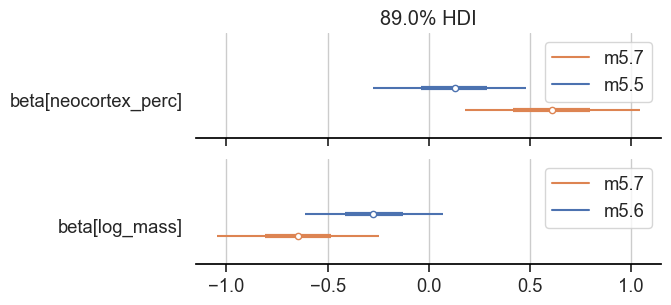

In [62]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6, 3))

az.plot_forest(
    [trace_5_5, trace_5_7],
    model_names=["m5.5", "m5.7"],
    var_names="beta",
    filter_vars="regex",
    coords={"features": ["neocortex_perc"]},
    hdi_prob=0.89,
    combined=True,
    ax=axs[0],
)

az.plot_forest(
    [trace_5_6, trace_5_7],
    model_names=["m5.6", "m5.7"],
    var_names="beta",
    filter_vars="regex",
    coords={"features": ["log_mass"]},
    hdi_prob=0.89,
    combined=True,
    ax=axs[1],
)
axs[1].set(title=None);

You can see that the parameter values become more extreme in the multiple regression model.